In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy
from scipy.integrate import solve_ivp
from scipy.integrate import LSODA as sp_lsoda
import xarray as xr
from numbalsoda import lsoda_sig, lsoda, dop853
from numba import njit, cfunc
import numba as nb

In [5]:
def M_l63_orig(x, dt, T, kwargs):
      s = kwargs['s']
      r = kwargs['r']
      b = kwargs['b']
      x2 = x
      for i in range(T):
            x[0] = x2[0] + dt*(s*(x2[1]-x2[0]))
            x[1] = x2[1] + dt*(x2[0]*(r-x2[2]) - x2[1])
            x[2] = x2[2] + dt*(x2[0]*x2[1] - b*x2[2])
            x2 = x
      return x

In [6]:
#Spin up
T = 1000
dt = 0.05
Nx = 3
params = {'s': 10, 'r': 28, 'b':8/3, 'F': 8, 
                      'l05_F':15, 'l05_Fe':15,
                      'l05_K':32, 'l05_I':12,  
                      'l05_b':10.0, 'l05_c':2.5}
xt_02 = 3*np.sin(np.arange(Nx)/(6*2*np.pi))
#rhs = make_rhs(params)
xt_f2 = M_l63_orig(xt_02, dt, T, params)

In [207]:
def dxt(t, x, s=10, b=8/3, r=28):
      dx = np.zeros(x.shape)
      s, b, r = 10, 8/3, 28
      dx[0] = s*(x[1]-x[0])
      dx[1] = x[0]*(r-x[2]) - x[1]
      dx[2] = x[0]*x[1] - b*x[2]
      return dx
def M_l63_sp(x, dt, T, kwargs):
      s = kwargs['s']
      r = kwargs['r']
      b = kwargs['b']
      tspan = np.array([0, dt*T])
      #usol = solve_ivp(dxt, tspan, x, t_eval=[tspan[-1]], args=(s, b, r))
      usol = sp_lsoda(dxt, 0, x, dt*T)
      while usol.status=='running':
            usol.step()
      return usol.y


In [208]:
#Spin up
T = 1000
dt = 0.05
Nx = 3
params = {'s': 10, 'r': 28, 'b':8/3, 'F': 8, 
                      'l05_F':15, 'l05_Fe':15,
                      'l05_K':32, 'l05_I':12,  
                      'l05_b':10.0, 'l05_c':2.5}
xt_03 = 3*np.sin(np.arange(Nx)/(6*2*np.pi))
#rhs = make_rhs(params)
xt_f3 = M_l63_sp(xt_03, dt, T, params)

In [246]:
print(lsoda_sig)

(float64, float64*, float64*, float64*) -> none


In [286]:
def make_rhs(kwargs):
      s = kwargs['s']
      r = kwargs['r']
      b = kwargs['b']      
      @cfunc(lsoda_sig)
      def rhs(t, u, du, p):
            du[0] = s*(u[1]-u[0])
            du[1] = u[0]*(r-u[2]) - u[1]
            du[2] = u[0]*u[1] - b*u[2]
      return rhs

def M_l63(x, dt, T, rhs):
      funcptr = rhs.address
      #tspan = np.linspace(0, dt*T, 1000)
      tspan = np.array([0, dt*T])
      usol, success = lsoda(funcptr, x, tspan)
      #usol, success = dop853(funcptr, x, tspan)
      return usol[-1, :]
                       

In [288]:
u = np.array([0, 0, 0])
du =  np.empty((3, ))
rhs(0, u, du, np.array([1.0]))

In [289]:
du

array([0., 0., 0.])

In [287]:
#Spin up
T = 1000
dt = 0.05
Nx = 3
params = {'s': 10, 'r': 28, 'b':8/3, 'F': 8, 
                      'l05_F':15, 'l05_Fe':15,
                      'l05_K':32, 'l05_I':12, 
                      'l05_b':10.0, 'l05_c':2.5}
xt_0 = 3*np.sin(np.arange(Nx)/(6*2*np.pi))
rhs = make_rhs(params)
xt_f = M_l63(xt_0, dt, T, rhs)

In [211]:
xt_f, xt_f2, xt_f3

(array([ 6.82413793,  8.80741273, 21.6804321 ]),
 array([ 4.44271734,  8.64173153, 13.91743061]),
 array([-5.46292472, -9.17024498, 14.72294536]))

In [ ]:
Nt = 500
xt = np.zeros((Nx, Nt))
xt2 = np.zeros((Nx, Nt))
xt3 = np.zeros((Nx, Nt))
xt[:, 0] = xt_f2
xt2[:, 0] = xt_f2
xt3[:, 0] = xt_f2
for t in range(Nt-1):
      u = copy.deepcopy(xt[:, t])
      xt[:, t+1] =  M_l63(u, dt, 1, rhs)
      xt2[:, t+1] = M_l63_orig(xt2[:, t], dt, 1, params)
      xt3[:, t+1] = M_l63_sp(xt3[:, t], dt, 1, params)

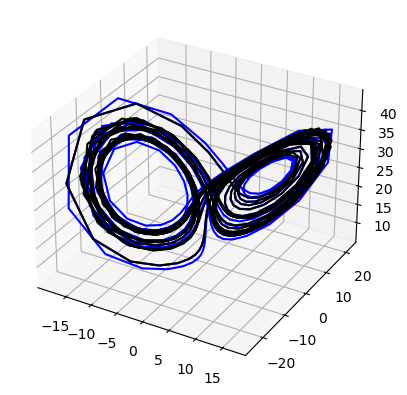

In [276]:
r = 1
t = -1
ts = np.linspace(0, 2*np.pi, Nx)
xs, ys = r*np.cos(ts), r*np.sin(ts)
#ensmin, ensmax = np.min(xt3), np.max(xt3)
i = 0
plt.close()
fig = plt.figure()
ax = plt.axes(projection = '3d')
#ax.plot3D(xs, ys, 0, ls = 'dashed')
#ax.scatter3D(xs, ys, xt[:, t])
ax.plot3D(xt[0, 0:t], xt[1, 0:t], xt[2, 0:t], c = 'blue')
ax.plot3D(xt3[0, 0:t], xt3[1, 0:t], xt3[2, 0:t], c = 'black')
#ax.plot3D(xt2[0, 0:t], xt2[1, 0:t], xt2[2, 0:t], c = 'red')
#ax.scatter3D(hxs, hys, Y[:, t, 0], 'red')
#ax.set_zlim((ensmin, ensmax))
i = i+1


In [26]:
def make_rhs_l96(kwargs):
      F = kwargs['F']
      Nx = 40
      @cfunc(lsoda_sig)
      def rhs(t, u, du, p):
            u_ = nb.carray(u, (Nx,))
            tmp = (np.roll(u_, -1) - np.roll(u_, 2))*np.roll(u_, 1) - u_ + F
            for i in range(Nx):
                  du[i] = tmp[i]
            #for i in range(Nx):
            #      if i < Nx - 2:
            #            du[i] = (u[i-1] - u[i+2])*u[i+1] - u[i] + F
            #      else:
            #            j = i - Nx
            #            du[i] = (u[j-1] - u[j+2])*u[j+1] - u[j] + F
      return rhs
def M_l96(x, dt, T, rhs):
      funcptr = rhs.address
      #tspan = np.linspace(0, dt*T, 1000)
      tspan = np.array([0, dt*T])
      usol, success = lsoda(funcptr, x, tspan)
      #usol, success = dop853(funcptr, x, tspan)
      return usol[-1, :]

In [27]:
#Spin up
T = 1000
dt = 0.05
Nx = 40
params = {'s': 10, 'r': 28, 'b':8/3, 'F': 8, 
                      'l05_F':15, 'l05_Fe':15,
                      'l05_K':32, 'l05_I':12, 
                      'l05_b':10.0, 'l05_c':2.5}
xt_0 = 3*np.sin(np.arange(Nx)/(6*2*np.pi))
rhs = make_rhs_l96(params)
xt_f = M_l96(xt_0, dt, T, rhs)

In [16]:
xt_f, xt_0

(array([0.        , 0.07956814, 0.1590803 , 0.23848053, 0.31771297,
        0.39672188, 0.47545166, 0.55384692, 0.63185251, 0.70941355,
        0.78647545, 0.86298401, 0.93888539, 1.01412619, 1.08865347,
        1.16241481, 1.23535829, 1.3074326 , 1.37858703, 1.44877152,
        1.51793668, 1.58603386, 1.65301513, 1.71883339, 1.78344231,
        1.84679643, 1.9088512 , 1.96956293, 2.02888893, 2.08678744,
        2.14321774, 2.19814011, 2.25151592, 2.30330762, 2.35347875,
        2.40199403, 2.44881933, 2.49392168, 2.53726937, 2.57883189]),
 array([0.        , 0.07956814, 0.1590803 , 0.23848053, 0.31771297,
        0.39672188, 0.47545166, 0.55384692, 0.63185251, 0.70941355,
        0.78647545, 0.86298401, 0.93888539, 1.01412619, 1.08865347,
        1.16241481, 1.23535829, 1.3074326 , 1.37858703, 1.44877152,
        1.51793668, 1.58603386, 1.65301513, 1.71883339, 1.78344231,
        1.84679643, 1.9088512 , 1.96956293, 2.02888893, 2.08678744,
        2.14321774, 2.19814011, 2.25151592, 2.

In [29]:
Nt = 500
xt = np.zeros((Nx, Nt))
xt[:, 0] = xt_f
for t in range(Nt-1):
      u = copy.deepcopy(xt[:, t])
      xt[:, t+1] =  M_l96(u, dt, 1, rhs)

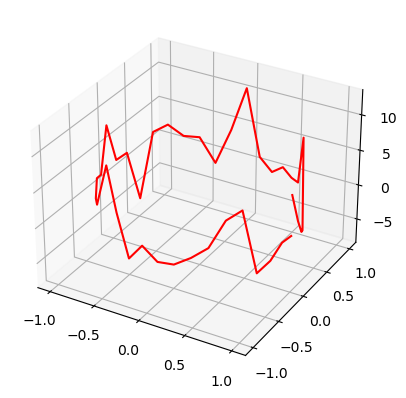

In [30]:
r = 1
ensmin, ensmax = np.min(xt), np.max(xt)
ts = np.linspace(0, 2*np.pi, Nx)
xs, ys = r*np.cos(ts), r*np.sin(ts)
i = 0
for t in range(100):
      plt.close()
      fig = plt.figure()
      ax = plt.axes(projection = '3d')
      #ax.plot3D(xs, ys, 0, ls = 'dashed')
      #ax.scatter3D(xs, ys, xt[:, t])
      ax.plot3D(xs, ys, xt[:, t], 'red')
      #ax.scatter3D(hxs, hys, Y[:, t, 0], 'red')
      ax.set_zlim((ensmin, ensmax))
      fig.savefig('./anims/frame_{:03d}.png'.format(i))
      i = i+1

In [ ]:
def M_nl05(z, dt, T, kwargs):
      K = kwargs['l05_K']
      I = kwargs['l05_I']
      b = kwargs['l05_b']
      c = kwargs['l05_c']
      F = kwargs['l05_F']
      Nx = z.shape[0]
      K = round(K)
      I = round(I)
      alpha = (3*I**2 + 3)/(2*I**3 + 4*I)
      beta = (2*I**2+1)/(I**4 + 2*I**2)

      tspan = np.array([0, T])*dt
      options = ' '

      def dzt(t, z0, K, I, b, c, F, alpha, beta, Nx):
            z0 = np.concatenate((z0, z0, z0))
            i = np.arange(-(I-1), I)
            if I == 1:
                  x0 = z0
            else:
                  x0 = np.zeros((Nx,))
                  for m in range(Nx):
                        n = Nx + m
                        x0[m] = np.sum((alpha - beta*np.abs(i))*z0[n+i]) + (alpha - beta*np.abs(-I))*z0[n-I]/2 + (alpha - beta*np.abs(I))*z0[n+I]/2
                  y0 = z0[Nx:2*Nx] - x0
            x0 = np.concatenate((x0, x0, x0))
            if I > 1:
                  y0 = np.concatenate([y0, y0, y0])
            w = np.zeros(x0.shape)
            J = int(np.floor(K/2))
            j = np.arange(-(J-1), J, dtype = np.int64)
            if K%2 ==0:
                  norm = 1/2
            else:
                  norm = 1
            for m in np.arange(Nx-2*K, 2*Nx+2*K):
                  w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K

            xx = np.zeros((Nx,))
            for m in range(Nx):
                  n = Nx + m 
                  xx[m] = -w[n-2*K]*w[n-K] + (np.sum(w[n-K+j]*x0[n+K+j]) + (w[n-K-J]*x0[n+K-J] + w[n-K+J]*x0[n+K+J])*norm)/K

            i1 = Nx + np.arange(-2, Nx-2)
            i2 = Nx + np.arange(-1, Nx-1)
            i3 = Nx + np.arange(0, Nx)
            i4 = Nx + np.arange(1, Nx+1)

            if I>1:
                  yy = -y0[i1]*y0[i2] + y0[i2]*y0[i4]
                  yx = -y0[i1]*x0[i2] + y0[i2]*x0[i4]
                  z1 = xx + (b**2)*yy + c*yx - x0[i3] - b*y0[i3] + F
            else:
                  z1 = xx - x0[i3] + F
            return z1
      final = solve_ivp(dzt, tspan, z, t_eval= [tspan[-1]], args = (K, I, b, c, F, alpha, beta, Nx))
      return final.y[:, 0]


In [58]:
@cfunc(lsoda_sig)
def dzt(t, z, dz, p):
      K, I, b, c = 32, 12, 10.0, 2.5
      F = 15
      K = np.round(K)
      I = np.round(I)
      alpha = (3*I*I + 3)/(2*I*I*I + 4*I)
      beta = (2*I*I+1)/(I*I*I*I + 2*I*I)
      Nx = 480
      z_ = nb.carray(z, (Nx,))
      z0 = np.concatenate((z_, z_, z_))
      i = np.arange(-(I-1), I, dtype=np.int16)
      if I == 1:
            x0 = z0
      else:
            x0 = np.empty_like(z0)
            for m in range(Nx):
                  n = Nx + m
                  x0[m] = np.sum((alpha - beta*np.abs(i))*z0[n+i]) + (alpha - beta*np.abs(-I))*z0[n-I]/2 + (alpha - beta*np.abs(I))*z0[n+I]/2
            y0 = z0[Nx:2*Nx] - x0[Nx:2*Nx]
      x0 = np.concatenate((x0, x0, x0))
      if I > 1:
            y0 = np.concatenate((y0, y0, y0))
      w = np.empty_like(x0)
      #J = int(np.floor(K/2))
      if K%2 ==0:
            norm = 1/2
            J = K/2
      else:
            norm = 1
            J = (K-1)/2
      j = np.arange(-(J-1), J, dtype=np.int16)
      J = int(J)
      #for n in range(4*K):
      #      m = n + Nx - 2*K
      #      w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
      for m in np.arange(Nx-2*K, 2*Nx+2*K):
            w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
      xx = np.zeros((Nx,))
      for m in range(Nx):
            n = Nx + m 
            xx[m] = -w[n-2*K]*w[n-K] + (np.sum(w[n-K+j]*x0[n+K+j]) + (w[n-K-J]*x0[n+K-J] + w[n-K+J]*x0[n+K+J])*norm)/K      
      i1 = Nx + np.arange(-2, Nx-2, dtype = np.int16)
      i2 = Nx + np.arange(-1, Nx-1, dtype = np.int16)
      i3 = Nx + np.arange(0, Nx, dtype = np.int16)
      i4 = Nx + np.arange(1, Nx+1, dtype = np.int16)

      if I>1:
            yy = -y0[i1]*y0[i2] + y0[i2]*y0[i4]
            yx = -y0[i1]*x0[i2] + y0[i2]*x0[i4]
            tmp = xx + (b*b)*yy + c*yx - x0[i3] - b*y0[i3] + F
      else:
            tmp = xx - x0[i3] + F
      for i in range(Nx):
            dz[i] = tmp[i]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy
from scipy.integrate import solve_ivp
from scipy.integrate import LSODA as sp_lsoda
import xarray as xr
from numbalsoda import lsoda_sig, lsoda, dop853
from numba import njit, cfunc
import numba as nb

In [4]:
K = int(params['l05_K'])
I = int(params['l05_I'])
b = params['l05_b']
c = params['l05_c']
F = params['l05_F']
Nx = 480
K = np.round(K)
I = np.round(I)
alpha = (3*I*I + 3)/(2*I*I*I + 4*I)
beta = (2*I*I+1)/(I*I*I*I + 2*I*I)
z = 3*np.sin(np.arange(Nx)/(6*2*np.pi))
dz = np.empty_like(z)
z0 = np.concatenate((z, z, z))
i = np.arange(-(I-1), I, dtype=np.int16)
if I == 1:
      x0 = z0
else:
      x0 = np.empty((Nx,))
      for m in range(Nx):
            n = Nx + m
            x0[m] = np.sum((alpha - beta*np.abs(i))*z0[n+i]) + (alpha - beta*np.abs(-I))*z0[n-I]/2 + (alpha - beta*np.abs(I))*z0[n+I]/2
      y0 = z0[Nx:2*Nx] - x0
x0 = np.concatenate((x0, x0, x0))
if I > 1:
      y0 = np.concatenate((y0, y0, y0))
w = np.empty((3*Nx))
#J = int(np.floor(K/2))
if K%2 == 0:
      norm = 1/2
      J = K/2
else:
      norm = 1
      J = (K-1)/2
j = np.arange(-(J-1), J, dtype=np.int16)
J = int(J)
#for n in range(4*K):
#      m = n + Nx - 2*K
#      w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
for m in np.arange(Nx-2*K, 2*Nx+2*K):
      #w[m] = m
      w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
xx = np.zeros((Nx,))
for m in range(Nx):
      n = Nx + m 
      xx[m] = -w[n-2*K]*w[n-K] + (np.sum(w[n-K+j]*x0[n+K+j]) + (w[n-K-J]*x0[n+K-J] + w[n-K+J]*x0[n+K+J])*norm)/K      
i1 = Nx + np.arange(-2, Nx-2, dtype = np.int16)
i2 = Nx + np.arange(-1, Nx-1, dtype = np.int16)
i3 = Nx + np.arange(0, Nx, dtype = np.int16)
i4 = Nx + np.arange(1, Nx+1, dtype = np.int16)

if I>1:
      yy = -y0[i1]*y0[i2] + y0[i2]*y0[i4]
      yx = -y0[i1]*x0[i2] + y0[i2]*x0[i4]
      tmp = xx + (b*b)*yy + c*yx - x0[i3] - b*y0[i3] + F
else:
      tmp = xx - x0[i3] + F
for n in range(Nx):
      #dz[i] = tmp[i]
      dz[n] = tmp[m]


In [ ]:
def make_rhs_l05(kwargs):
      K = int(kwargs['l05_K'])
      I = int(kwargs['l05_I'])
      b = kwargs['l05_b']
      c = kwargs['l05_c']
      F = kwargs['l05_F']
      Nx = 480
      K = np.round(K)
      I = np.round(I)
      alpha = (3*I**2 + 3)/(2*I**3 + 4*I)
      beta = (2*I**2+1)/(I**4 + 2*I**2)
      @cfunc(lsoda_sig)
      def rhs(t, z, dz, p):
            z_ = nb.carray(z, (Nx,))
            z0 = np.concatenate((z_, z_, z_))
            i = np.arange(-(I-1), I, dtype=np.int64)
            if I == 1:
                  x0 = z0
            else:
                  x0 = np.empty((Nx,))
                  for m in range(Nx):
                        n = Nx + m
                        x0[m] = np.sum((alpha - beta*np.abs(i))*z0[n+i]) + (alpha - beta*np.abs(-I))*z0[n-I]/2 + (alpha - beta*np.abs(I))*z0[n+I]/2
                  y0 = z0[Nx:2*Nx] - x0
            x0 = np.concatenate((x0, x0, x0))
            if I > 1:
                  y0 = np.concatenate((y0, y0, y0))
            w = np.empty((3*Nx))
            J = int(np.floor(K/2))
            j = np.arange(-(J-1), J, dtype = np.int64)
            if K%2 == 0:
                  norm = 1/2
            else:
                  norm = 1
            j = np.arange(-(J-1), J, dtype=np.int64)
            J = int(J)
            #for n in range(4*K):
            #      m = n + Nx - 2*K
            #      w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
                  #w[m] = m
            for m in np.arange(Nx-2*K, 2*Nx+2*K):
                   w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
            xx = np.empty((Nx,))
            for m in range(Nx):
                  n = Nx + m 
                  xx[m] = -w[n-2*K]*w[n-K] + (np.sum(w[n-K+j]*x0[n+K+j]) + (w[n-K-J]*x0[n+K-J] + w[n-K+J]*x0[n+K+J])*norm)/K
            i1 = Nx + np.arange(-2, Nx-2, dtype = np.int16)
            i2 = Nx + np.arange(-1, Nx-1, dtype = np.int16)
            i3 = Nx + np.arange(0, Nx, dtype = np.int16)
            i4 = Nx + np.arange(1, Nx+1, dtype = np.int16)

            if I>1:
                  yy = -y0[i1]*y0[i2] + y0[i2]*y0[i4]
                  yx = -y0[i1]*x0[i2] + y0[i2]*x0[i4]
                  tmp = xx + (b**2)*yy + c*yx - x0[i3] - b*y0[i3] + F
            else:
                  tmp = xx - x0[i3] + F
            for n in range(Nx):
                  dz[n] = tmp[n]
      return rhs

def M_l05(x, dt, T, rhs):
      funcptr = rhs.address
      #tspan = np.linspace(0, dt*T, 1000)
      tspan = np.array([0, dt*T])
      usol, success = lsoda(funcptr, x, tspan)
      #usol, success = dop853(funcptr, x, tspan)
      return usol[-1, :]

In [8]:
#Spin up
T = 1000
Nt = 100
dt = 0.05
Nx = 480
params = {'s': 10, 'r': 28, 'b':8/3, 'F': 8, 
                      'l05_F':15, 'l05_Fe':15,
                      'l05_K':32, 'l05_I':12, 
                      'l05_b':10.0, 'l05_c':2.5}
xt_0 = 3*np.sin(np.arange(Nx)/(6*2*np.pi))
rhs = make_rhs_l05(params)
xt_f = xt_0
for t in range(Nt-1):
      xt_tmp = copy.deepcopy(xt_f)
      xt_f =  M_l05(xt_tmp, dt, 1, rhs)

In [10]:
Nt = 500
xt = np.zeros((Nx, Nt))
xt[:, 0] = xt_f
for t in range(Nt-1):
      u = copy.deepcopy(xt[:, t])
      xt[:, t+1] =  M_l05(u, dt, 1, rhs)

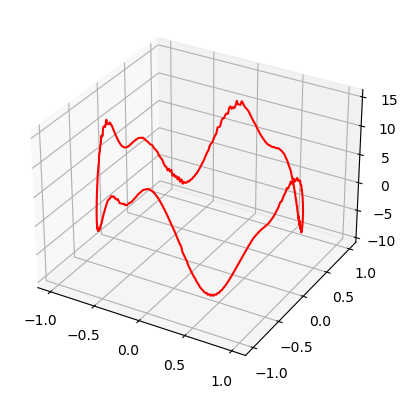

In [11]:
r = 1
ensmin, ensmax = np.min(xt), np.max(xt)
ts = np.linspace(0, 2*np.pi, Nx)
xs, ys = r*np.cos(ts), r*np.sin(ts)
i = 0
for t in range(100):
      plt.close()
      fig = plt.figure()
      ax = plt.axes(projection = '3d')
      #ax.plot3D(xs, ys, 0, ls = 'dashed')
      #ax.scatter3D(xs, ys, xt[:, t])
      ax.plot3D(xs, ys, xt[:, t], 'red')
      #ax.scatter3D(hxs, hys, Y[:, t, 0], 'red')
      ax.set_zlim((ensmin, ensmax))
      fig.savefig('./anims/frame_{:03d}.png'.format(i))
      i = i+1

In [160]:
params = {'s': 10, 'r': 28, 'b':8/3, 'F': 8, 
                      'l05_F':15, 'l05_Fe':15,
                      'l05_K':32, 'l05_I':12, 
                      'l05_b':10.0, 'l05_c':2.5}
rhs = make_rhs_l05(params)
Nx = 480
u =3*np.sin(np.arange(Nx)/(6*2*np.pi))
du = np.zeros((Nx,))
p = np.array([1.0])
t = 1.0
du

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [161]:
import ctypes
LP_c_double = (ctypes.c_double)
LP_c_double_480 = (ctypes.c_double * Nx)
LP_c_double_1 = (ctypes.c_double * 1)
u_ = LP_c_double_480(*u)
du_ = LP_c_double_480(*du)
t_ = LP_c_double(t)
p_ = LP_c_double_1(p)
u1 = ctypes.c_double(u_[0])
du1 = ctypes.c_double(du_[0])
p1  = ctypes.c_double(p_[0])
tptr, uptr, duptr, pptr = ctypes.pointer(t_), ctypes.cast(u_, ctypes.POINTER(ctypes.c_double)),  ctypes.cast(du_, ctypes.POINTER(ctypes.c_double)),  ctypes.cast(p_, ctypes.POINTER(ctypes.c_double))

In [162]:
rhs.ctypes(t_, uptr, duptr, pptr)